In [1]:
import os
import torch
import matplotlib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

import utils.model as model
import utils.dataset as dataset
import utils.skel as skel
from utils.utils import create_folder, save_args, save_configs, generate_unique_run_name
import torch.optim as optim

os.environ['TRANSFORMERS_CACHE'] = 'transformer_cache/'
from utils.dataset import SIGNUMDataset
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter

from runner import basic_test
from utils.skel import TB_vis_pose2D, prep_poses, TB_vis_pose2D_GT

In [2]:
def calculate_batch_mpjpe(output, label):
    difference =  output - label 
    square_difference = torch.square(difference) 
    sum_square_difference_per_point = torch.sum(square_difference, dim=2) 
    euclidean_distance_per_point = torch.sqrt(sum_square_difference_per_point) 
    return euclidean_distance_per_point

In [3]:
batch_size = 1 #Fixed to 1
dataset_root = '/scratch/datasets/SIGNUM'
num_workers = 0
subsample = 10


encoder_type = "multi"
# encoder_type = "en"
# encoder_type = "de"


speaker_id = str(11)
print('Running Evaluation for {} on Speaker {}'.format(encoder_type, speaker_id))

run_num = 0
model_path = 'model-best'

device = device = torch.device("cuda:{}".format(1) if torch.cuda.is_available() else "cpu")

"""LOAD THE DATASET"""
test_dataset = SIGNUMDataset('/scratch/datasets/SIGNUM', use_pose=True, subsample=subsample,\
                              testing=True, normalize_poses=True, speaker_id=speaker_id)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, \
                                                num_workers=num_workers, collate_fn=test_dataset.collate)

print('Testing Examples: {}'.format(len(test_dataset)))

# Initialize Models
print('INITIALIZING MODELS')
encoder = model.language_encoder(model_type=encoder_type)
for param in encoder.parameters():
    param.requires_grad = False

encoder.eval()

"""SET THE MODEL NAME"""
if encoder_type == "multi":
    model_name = "multi_run={}".format(run_num)
elif encoder_type == "en":
    model_name = "english_run={}".format(run_num)
else: # encoder_type == "de"
    model_name = "german_run={}".format(run_num)

decoder = model.Decoder(hidden_size=768, pose_size=57*2, trajectory_size=0,
                           use_h=False, start_zero=False, use_tp=False,
                           use_lang=False, use_attn=False).to(device)

model_file = os.path.join(model_path, model_name, "lowest_validation_model.tar")
checkpoint = torch.load(model_file, map_location=device)
print("LOADING: {} from training epoch {}".format(model_file, checkpoint["epoch"]))
decoder.load_state_dict(checkpoint["model_state_dict"])
decoder.eval()

Running Evaluation for multi on Speaker 11
Testing Examples: 78
INITIALIZING MODELS
LOADING: model-best/multi_run=0/lowest_validation_model.tar from training epoch 60


Decoder(
  (cell): DecoderCell(
    (rnn): GRUCell(114, 768)
    (tp): Linear(in_features=768, out_features=114, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (spacial_attention): ModuleList(
    (0): SpacialAttention(
      (softmax): Softmax(dim=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (temporal_attention): ModuleList(
    (0): TemporalAttention(
      (Q): Linear(in_features=768, out_features=768, bias=True)
      (K): Linear(in_features=768, out_features=768, bias=True)
      (V): Linear(in_features=768, out_features=768, bias=True)
      (softmax): Softmax(dim=2)
    )
  )
  (attention_mlps): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
    )
  )
)

In [35]:
# input_lang = 'en'
input_lang = 'de'

num_joints = 57
joint_dim = 2

encoder.eval()
decoder.eval()

all_loss = 0
for i, data in enumerate(test_loader):
    print(i)
#     if i == 10:
#         break
    img_seq = torch.FloatTensor(data['img_seq'])
    pose_seq = data['pose_seq'].to(device)
    label_seq = data['label_seq'].to(device)
    transl_eng = data['transl_eng']
    transl_deu = data['transl_deu']
    multilingual = data['multi']
    img_seq_len = data['seq_len']

    total_sequence = sum(np.array(img_seq_len))
    delta = label_seq - pose_seq

    if encoder_type == 'multi':
#             print('multi')
        if input_lang == 'en':
            encoder_input = transl_eng
        else:
            encoder_input = transl_deu
        
    elif encoder_type == 'en':
#             print('en')
        encoder_input = transl_eng
        input_lang = 'en'
    else:
#             print('de')
        encoder_input = transl_deu
        input_lang = 'de'
    
    print(encoder_type)
    print(input_lang)
#     print("Encoder Input: ", encoder_input)
#     print("English Input: ", transl_eng)
#     print("German Input: ", transl_deu)

    lang_embed = torch.FloatTensor(encoder(encoder_input)).to(device)

    output = decoder.sample(lang_embed.to(device), max(img_seq_len), \
                             pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1)[:,0,...].to(device),\
                             attn=None)

    packed = dataset.pack_sequence(output, np.array(img_seq_len))
    pred_pose = packed.data.view(-1,num_joints*joint_dim)

    packed_gt = dataset.pack_sequence(label_seq, np.array(img_seq_len))
    gt_label = packed_gt.data.view(-1, num_joints*joint_dim)

    pred_pose = skel.denormalize_pose(pred_pose.view(-1, num_joints, joint_dim).detach().cpu())
    gt_label = skel.denormalize_pose(gt_label.view(-1, num_joints, joint_dim).detach().cpu())
    loss = calculate_batch_mpjpe(pred_pose, gt_label)
    print(loss.shape)
    
    loss = torch.mean(loss, dim=0)
    print(loss.shape)

    all_loss += loss.detach().cpu()
    
#     %matplotlib inline
#     normalize_poses = True

#     size = img_seq_len * 1
#     print("ENCODER TYPE: ", encoder_type)
#     print("INPUT TYPE: ", input_lang)
#     print("ENCODER INPUT: ", encoder_input)
#     fig = TB_vis_pose2D(packed, packed_gt, normalize_poses)
# #     fig.set_size_inches(size, 1, forward=True)
#     plt.show()
#     fig.savefig('figures/{}-{}-{}-{}.png'.format(i, encoder_type, input_lang, encoder_input[0]), bbox_inches='tight', dpi=200)

all_loss = all_loss / len(test_loader)
print("DONE")

0
multi
de
torch.Size([21, 57])
torch.Size([57])
1
multi
de
torch.Size([21, 57])
torch.Size([57])
2
multi
de
torch.Size([22, 57])
torch.Size([57])
3
multi
de
torch.Size([17, 57])
torch.Size([57])
4
multi
de
torch.Size([18, 57])
torch.Size([57])
5
multi
de
torch.Size([16, 57])
torch.Size([57])
6
multi
de
torch.Size([18, 57])
torch.Size([57])
7
multi
de
torch.Size([27, 57])
torch.Size([57])
8
multi
de
torch.Size([18, 57])
torch.Size([57])
9
multi
de
torch.Size([18, 57])
torch.Size([57])
10
multi
de
torch.Size([24, 57])
torch.Size([57])
11
multi
de
torch.Size([24, 57])
torch.Size([57])
12
multi
de
torch.Size([22, 57])
torch.Size([57])
13
multi
de
torch.Size([17, 57])
torch.Size([57])
14
multi
de
torch.Size([20, 57])
torch.Size([57])
15
multi
de
torch.Size([19, 57])
torch.Size([57])
16
multi
de
torch.Size([20, 57])
torch.Size([57])
17
multi
de
torch.Size([20, 57])
torch.Size([57])
18
multi
de
torch.Size([23, 57])
torch.Size([57])
19
multi
de
torch.Size([26, 57])
torch.Size([57])
20
multi
d

In [36]:
# error per joint
all_loss = list(all_loss)
body = all_loss[:4] + all_loss[5:7] + all_loss[8:15]
hands = all_loss[4:5] + all_loss[7:8] + all_loss[15:]
print(len(body))
print(len(hands))

13
44


In [37]:
print(torch.mean(torch.tensor(body)))
print(torch.mean(torch.tensor(hands)))

tensor(4.9561)
tensor(61.9024)


0
torch.Size([21, 57, 2])
0


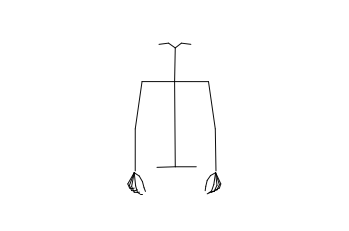

1


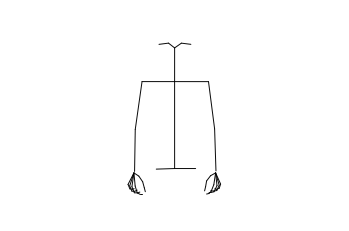

2


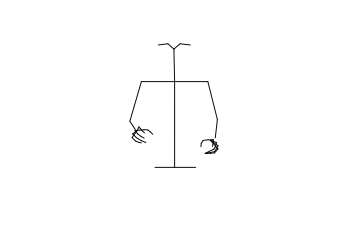

3


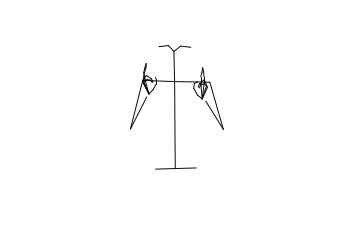

4


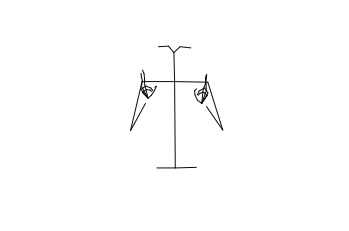

5


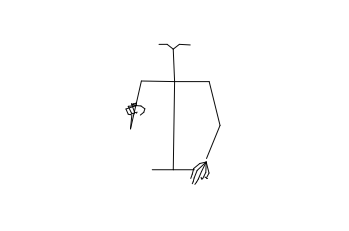

6


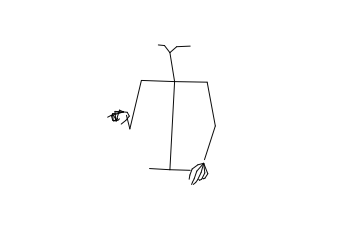

7


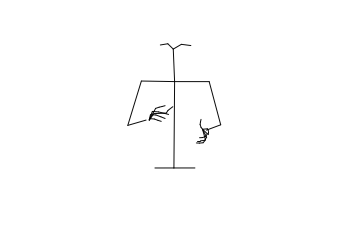

8


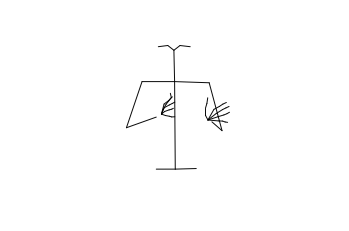

9


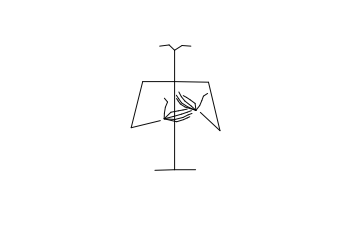

10


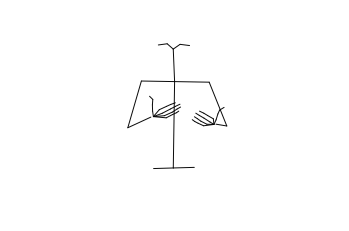

11


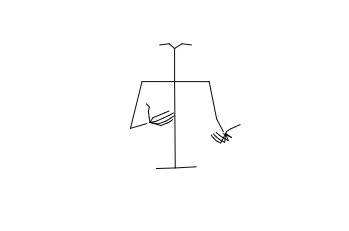

12


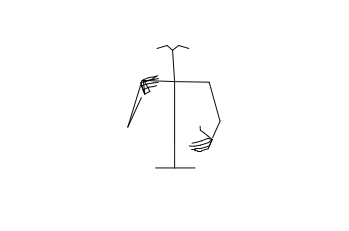

13


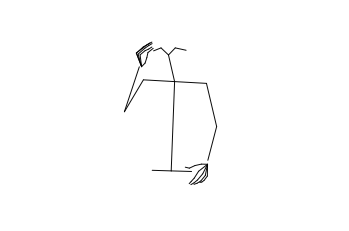

14


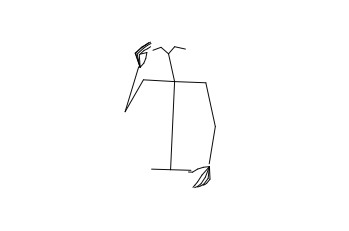

15


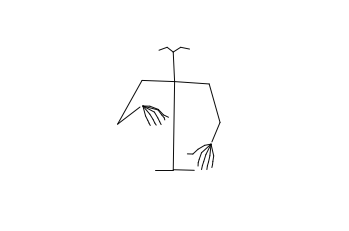

16


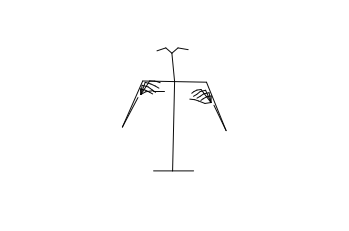

17


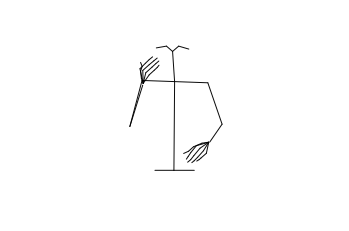

18


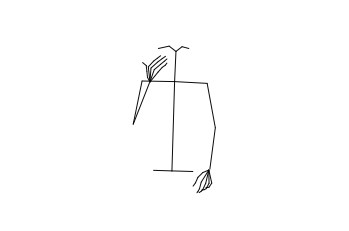

19


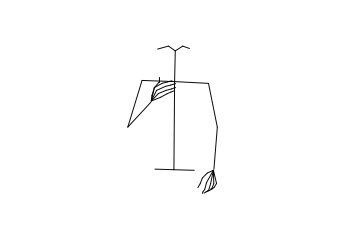

20


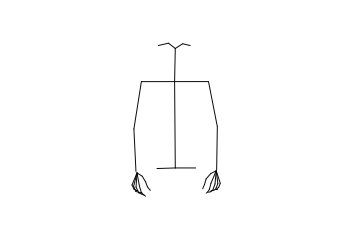

0


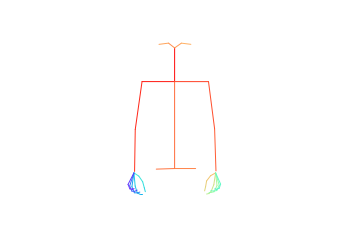

1


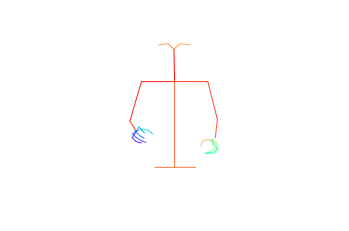

2


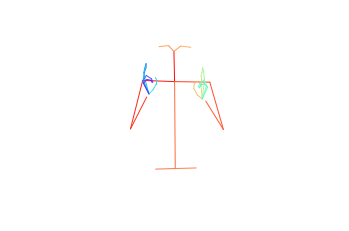

3


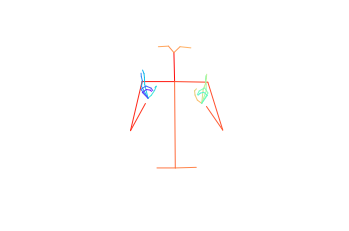

4


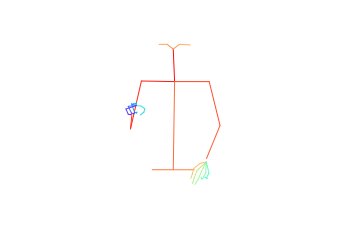

5


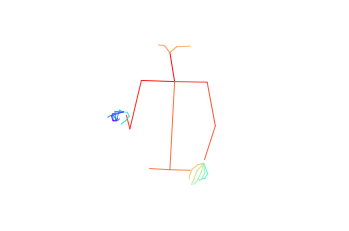

6


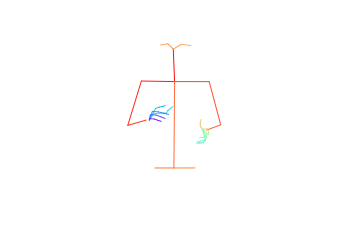

7


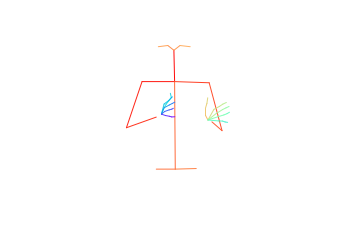

8


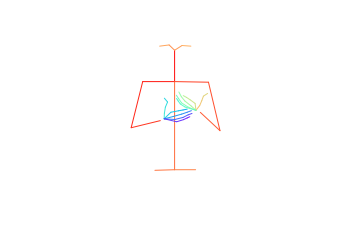

9


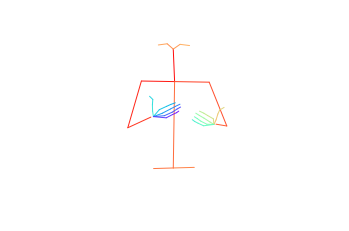

10


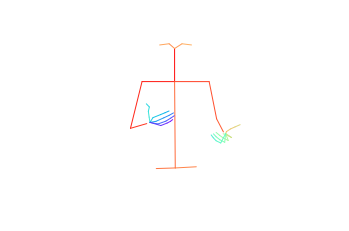

11


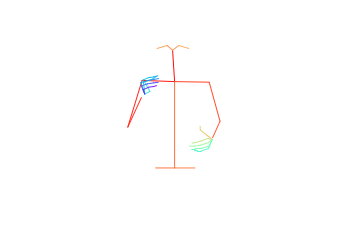

12


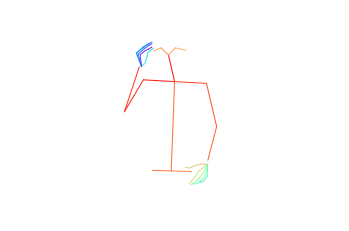

13


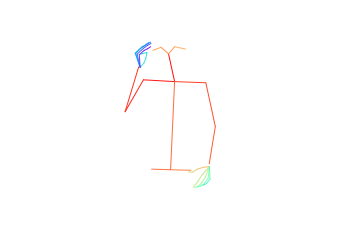

14


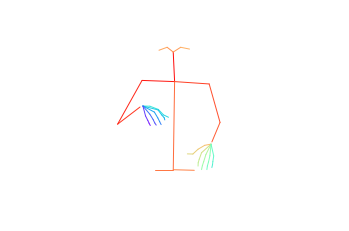

15


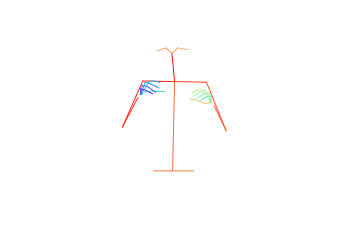

16


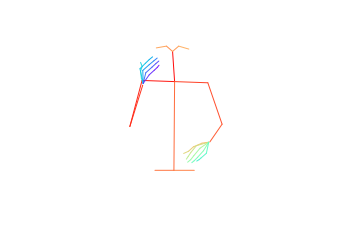

17


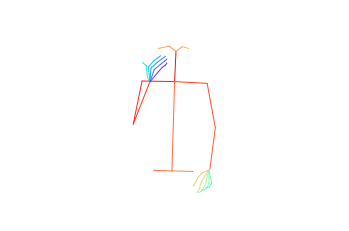

18


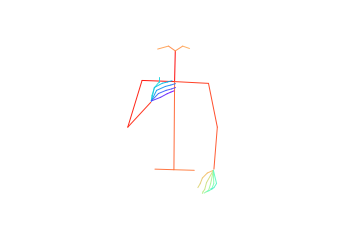

19


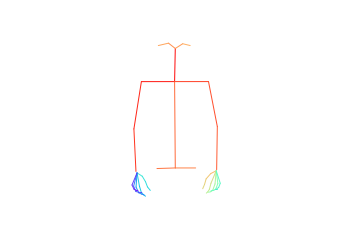

20


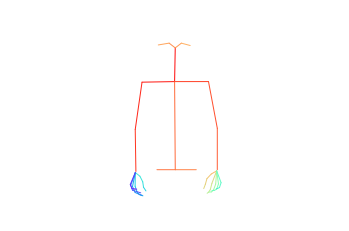

1


In [12]:
from utils.skel import TB_vis_pose2D_GT
for i, data in enumerate(test_loader):
    print(i)
    if i == 1:
        break
    img_seq = torch.FloatTensor(data['img_seq'])
    pose_seq = data['pose_seq'].to(device)
    label_seq = data['label_seq'].to(device)
    transl_eng = data['transl_eng']
    transl_deu = data['transl_deu']
    multilingual = data['multi']
    img_seq_len = data['seq_len']

    total_sequence = sum(np.array(img_seq_len))
    delta = label_seq - pose_seq
    
    
    %matplotlib inline
    normalize_poses = True
    
    packed = dataset.pack_sequence(pose_seq, np.array(img_seq_len))
    packed_gt = dataset.pack_sequence(label_seq, np.array(img_seq_len))
    
    vis_pose, vis_gt, len_pose, len_gt = prep_poses(packed, packed_gt, num_joints=57, joint_dim=2, normalize=True)
    print(vis_gt.shape)
    
    
    for k, pose in enumerate(vis_pose):
        fig = plt.figure()
    #     clear_output(wait=True)
        print(k)
        ax = plt.subplot(111)
#         pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
#         pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)

    #     print(pose.shape)
#         skel.plot_pose2D(ax, pose)
        skel.plot_pose2D(ax, pose, colormap='copper', gt=True)
        ax.axis('off')
        plt.show()
        fig.savefig('figures/GT/{}.jpg'.format(k), bbox_inches='tight', dpi=200)
        
    for k, pose in enumerate(vis_gt):
        fig = plt.figure()
    #     clear_output(wait=True)
        print(k)
        ax = plt.subplot(111)
#         pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
#         pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)

    #     print(pose.shape)
#         skel.plot_pose2D(ax, pose)
        skel.plot_pose2D(ax, pose, colormap='rainbow', gt=False)
        ax.axis('off')
        plt.show()
        fig.savefig('figures/GT/pred-{}.jpg'.format(k), bbox_inches='tight', dpi=200)